In [5]:
# Ensure repo root is on sys.path so `import src...` works from notebooks/
from pathlib import Path
import os
import sys

repo_root = Path.cwd()
# If we're in notebooks/, go up one; otherwise this is a no-op.
if repo_root.name == "notebooks":
    repo_root = repo_root.parent

# Make relative paths (like data/...) resolve from repo root
os.chdir(repo_root)
sys.path.insert(0, str(repo_root))

# Optional: quick sanity print
print("Repo root:", repo_root)

Repo root: /home/e20094/e20-4yp-backdoor-resilient-federated-nids


In [6]:
from src.data.preprocess import clean_and_process
clean_and_process()

🚀 Starting Data Preprocessing Pipeline...
   📂 Loading raw files from /home/e20094/e20-4yp-backdoor-resilient-federated-nids/data/unsw-nb15/raw...
   ✅ Merged Dataset Shape: (257673, 45)
   ℹ️ Class Mapping: {'Analysis': 1, 'Backdoor': 2, 'DoS': 3, 'Exploits': 4, 'Fuzzers': 5, 'Generic': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9, 'Normal': 0}
   ✅ Data Split: Train (206138, 42), Test (51535, 42)
   ⚖️ Fitting Scalers on TRAIN set only...
   🏷️ Encoding Categorical (Top-10 from TRAIN only)...
   💾 Saving PyTorch Tensors...
   ✅ Done! 


## 🎯 Purpose: Is this problem even learnable?

### What need to be done
- Apply **UMAP only on training data** (no test data involved)
- Use `n_neighbors=15`, `min_dist=0.1`
- Color points by **attack category** (`attack_cat`)

### What need to be checked
- Do attacks sometimes separate from normal?
- Are some attack types fully overlapping?

### Correct interpretation
- **Overlap ≠ bad preprocessing**
- UNSW-NB15 is **intrinsically overlapping** in feature space

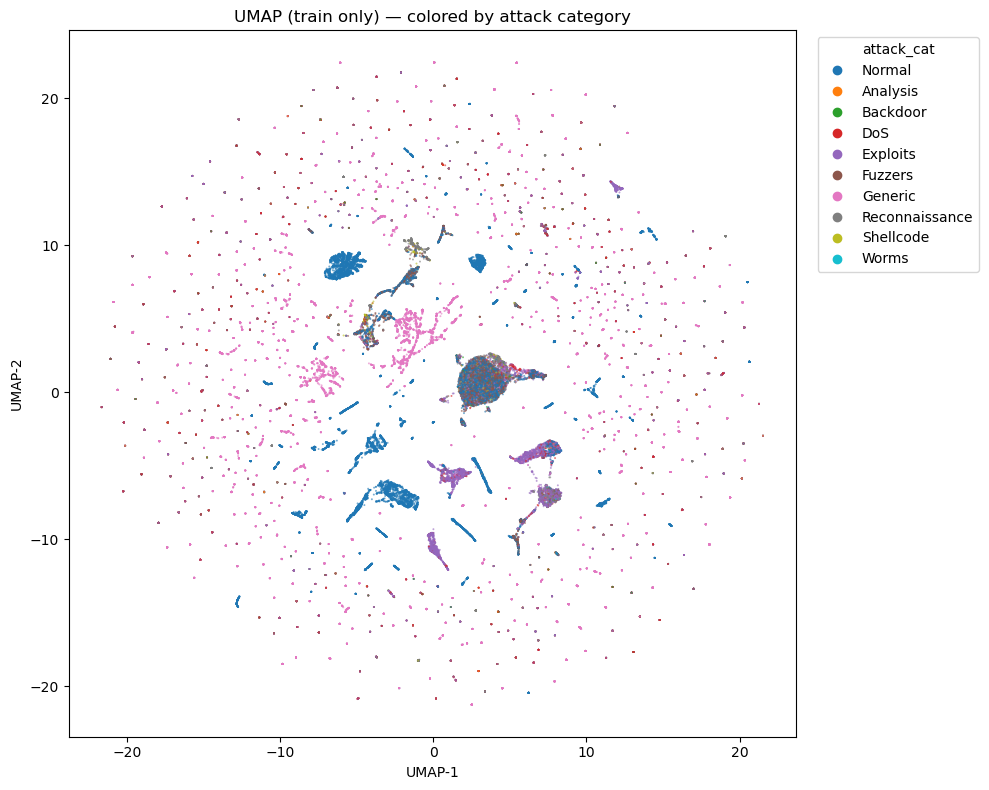

Visualized 50,000 points from TRAIN (total train: 206,138)


In [7]:
from pathlib import Path
import warnings

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import torch

# Suppress warnings in this cell output (e.g., tqdm/ipywidgets warnings)
warnings.filterwarnings("ignore")
try:
    from tqdm import TqdmWarning
    warnings.filterwarnings("ignore", category=TqdmWarning)
except Exception:
    pass

# UMAP comes from the `umap-learn` package
import umap.umap_ as umap

# --- Load TRAIN ONLY (no test data) ---
train_path = Path("data/unsw-nb15/processed/train_pool.pt")
if not train_path.exists():
    # If preprocessing wasn't run (or outputs were deleted), generate them.
    from src.data.preprocess import clean_and_process
    clean_and_process()

train_payload = torch.load(train_path, map_location="cpu")
X_train = train_payload["X"].numpy()
y_train = train_payload["y"].numpy()
label_map = train_payload.get("label_map", None)
inv_label_map = {v: k for k, v in label_map.items()} if isinstance(label_map, dict) else None

# --- Subsample for faster visualization (still TRAIN data) ---
rng = np.random.default_rng(42)
max_points = 50_000
if X_train.shape[0] > max_points:
    idx = rng.choice(X_train.shape[0], size=max_points, replace=False)
    X_vis = X_train[idx]
    y_vis = y_train[idx]
else:
    X_vis, y_vis = X_train, y_train

# --- UMAP (fit on TRAIN only) ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
emb = reducer.fit_transform(X_vis)

# --- Plot colored by attack category ---
plt.figure(figsize=(10, 8))
plt.scatter(
    emb[:, 0],
    emb[:, 1],
    c=y_vis,
    cmap="tab10",
    s=2,
    alpha=0.6,
    linewidths=0,
 )
plt.title("UMAP (train only) — colored by attack category")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Build a readable legend (names if available)
handles = []
for cls in sorted(np.unique(y_vis)):
    cls_int = int(cls)
    label = inv_label_map.get(cls_int, str(cls_int)) if inv_label_map else str(cls_int)
    color = plt.cm.tab10(cls_int % 10)
    handles.append(
        mlines.Line2D([], [], color=color, marker="o", linestyle="None", markersize=6, label=label)
    )
plt.legend(handles=handles, title="attack_cat", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(f"Visualized {X_vis.shape[0]:,} points from TRAIN (total train: {X_train.shape[0]:,})")